# Fast Fourier Transform & Denoising
comparacion entre tecnicas para limpiar ruido
- Usar promedios para suavizar
- Usar la FFT (Transformada Rapida de Fourier)

## La FFT
Tengamos $x, y[x)$ como un punto de data, donde se pueden expresar los datos como una combinacion de componentes sinusoidales de frecuencia $\omega_k = \frac{2\pi}{L}k$,

Se ha de tener en cuenta que los datos son discretos, por tanto, tengamos $x_n, y_n$ como un punto de data
$$y[x) \rightarrow y_n$$

con el cambio a discretos
$$ y_n = \frac{1}{N} \sum_{k=0}^{N-1} c_k \exp(i \frac{2\pi x_n}{L}k)  $$
$$ y_n = \frac{1}{N} \sum_{k=0}^{N-1} c_k \exp(i \omega_k x_n)  $$

donde:
$$ x_n = \frac{n}{N}L$$
de esa manera, $x$ va tomando las distintas posiciones equiespaciadas con el indice $n$, asi dejamos de depender del intervalo $L$ y solo de la cantidad de datos $N$ y el indice $n$

$$
y_n = \frac{1}{N} \sum_{k=0}^{N-1} c_k \exp(i \frac{2\pi k}{N} n) 
$$

# Que se hara en este Notebook?
Conseguir un algoritmo para filtrar datos de alta frecuencia, dejandolo asi en un formato de coeficientes para poder alimentarse a un clasificador (Machine Learning), sin embargo se quedara en el contexto de obtener coeficienes y demostrar como cambia la data luego de aplicar limpieza de ruido.

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.fft import *
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

## 1 - Cargando la DAta

Descripcion de la competicion y los datos:

Faults in electric transmission lines can lead to a destructive phenomenon called partial discharge.
If left alone, partial discharges can damage equipment to the point that it stops functioning entirely. Your challenge is to detect partial discharges so that repairs can be made before any lasting harm occurs.

Each signal contains 800,000 measurements of a power line's voltage, taken over 20 milliseconds. As the underlying electric grid operates at 50 Hz, this means each signal covers a single complete grid cycle. The grid itself operates on a 3-phase power scheme, and all three phases are measured simultaneously.

- metadata_[train/test].csv

id_measurement: the ID code for a trio of signals recorded at the same time.
signal_id: the foreign key for the signal data. Each signal ID is unique across both train and test, so the first ID in train is '0' but the first ID in test is '8712'.

phase: the phase ID code within the signal trio. The phases may or may not all be impacted by a fault on the line.

target: 0 if the power line is undamaged, 1 if there is a fault.

- [train/test].parquet 

The signal data. Each column contains one signal; 800,000 int8 measurements as exported with pyarrow.parquet version 0.11. 

Please note that this is different than our usual data orientation of one row per observation; the switch makes it possible loading a subset of the signals efficiently. If you haven't worked with Apache Parquet before, please refer to either the Python data loading starter kernel.

### Señales o Signals
Se ha de entender que tenemos 333 mediciones, en el archivo se observaran 999 pues corresponde a cada fase de la linea de transmision, son 3.

Por tanto comenzaremos separando estos 3 fases en fase 0,1,2 para poder trabajar con ellas por separado

Lo que se busca se encuentra en `metadata_train.csv`, donde se separa en 333 mediciones distintas y algunas de ellas poseen fallas, lo que busca este analizis es identificar esas fallas observando solamente las señales.

In [16]:
# la data se guarda como pandas
# son 999 signals distintas, 333 mediciones distintas con (N = 800000 muestras)
signals = pq.read_table('../input/train.parquet', columns=[str(i) for i in range(999)]).to_pandas()
print(signals.shape)
# data vs signal type
signals


(800000, 999)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998
0,18,1,-19,-16,-5,19,-15,15,-1,-16,-9,23,-1,-17,16,-8,17,-10,21,-8,-12,-7,23,-15,-20,13,4,-20,1,15,13,-2,-17,5,16,-20,9,-16,7,10,...,17,13,1,-20,-11,-12,17,-21,19,4,13,-17,0,17,3,-20,-14,19,-4,18,-5,-19,19,-17,1,-20,7,15,14,-21,4,-18,10,9,18,-20,1,18,-19,-6
1,18,0,-19,-17,-6,19,-17,16,0,-15,-10,22,0,-16,17,-7,17,-10,20,-9,-12,-7,24,-14,-20,14,4,-20,1,15,14,-3,-18,5,16,-20,9,-15,7,9,...,16,14,2,-19,-7,-8,19,-20,20,4,13,-17,1,17,3,-20,-17,20,-5,14,-3,-17,18,-19,0,-21,8,17,14,-22,1,-20,8,8,20,-19,2,18,-18,-6
2,17,-1,-20,-17,-6,19,-17,15,-3,-15,-10,22,-1,-16,17,-9,16,-11,20,-8,-12,-6,24,-14,-20,13,4,-20,1,15,11,-3,-18,5,16,-20,8,-16,7,10,...,16,14,1,-20,-10,-12,17,-20,20,4,14,-16,1,17,4,-20,-15,18,-6,23,-1,-16,17,-21,-1,-22,7,13,15,-22,1,-20,6,6,17,-22,0,18,-18,-6
3,18,1,-19,-16,-5,20,-16,16,0,-15,-9,22,-1,-17,17,-7,18,-9,21,-8,-12,-5,25,-14,-21,14,4,-20,1,15,14,-3,-17,5,16,-20,8,-16,7,10,...,17,14,1,-19,-8,-10,19,-20,20,5,14,-17,2,17,4,-20,-15,21,-3,19,-2,-17,17,-22,-2,-20,9,17,15,-21,3,-21,5,6,18,-19,1,18,-18,-6
4,18,0,-19,-16,-5,20,-17,16,-2,-14,-8,24,-2,-17,16,-9,16,-11,20,-8,-13,-6,24,-13,-21,14,4,-20,1,15,14,-3,-18,4,16,-21,8,-16,7,10,...,14,14,2,-18,-7,-10,18,-20,20,4,14,-17,1,18,4,-20,-17,19,-7,18,-2,-16,18,-20,-1,-22,9,14,13,-22,3,-20,5,6,19,-21,1,19,-18,-5
5,18,0,-20,-15,-4,20,-16,15,-2,-12,-7,25,-1,-17,16,-8,18,-10,21,-8,-13,-5,25,-13,-21,14,5,-20,1,15,12,-3,-17,4,15,-21,9,-16,6,11,...,17,14,1,-19,-9,-11,18,-21,19,4,14,-17,2,17,3,-20,-14,19,-5,17,-5,-19,19,-19,0,-22,6,14,15,-22,0,-20,6,7,18,-20,0,19,-18,-6
6,19,1,-18,-16,-5,20,-16,16,-1,-13,-7,26,0,-16,17,-7,18,-9,21,-8,-11,-6,24,-14,-20,14,5,-20,1,14,13,-3,-18,4,15,-21,9,-15,7,10,...,15,14,2,-20,-7,-10,18,-21,19,3,14,-17,1,18,4,-20,-16,21,-5,20,0,-16,18,-19,0,-19,10,17,15,-21,1,-19,7,8,18,-21,1,19,-18,-5
7,18,0,-19,-17,-7,18,-17,15,-2,-15,-9,23,1,-16,18,-9,16,-11,20,-9,-14,-6,23,-15,-20,14,4,-19,2,16,13,-3,-18,3,15,-22,9,-16,7,9,...,15,15,3,-18,-9,-10,18,-22,18,3,13,-17,1,18,4,-20,-16,17,-7,21,-2,-17,18,-19,0,-22,7,13,14,-21,4,-18,9,9,18,-20,1,20,-17,-5
8,18,0,-20,-18,-7,18,-16,15,-2,-16,-9,23,0,-16,17,-8,18,-10,20,-8,-12,-7,23,-15,-21,13,4,-19,2,16,12,-3,-17,3,15,-22,9,-16,7,9,...,18,15,1,-20,-9,-11,17,-21,18,4,14,-17,1,18,4,-20,-12,21,-3,13,-7,-20,17,-21,-1,-20,8,17,15,-22,1,-19,8,8,18,-21,0,20,-17,-5
9,17,0,-19,-17,-7,18,-17,17,-1,-14,-9,23,-1,-17,16,-8,16,-10,21,-8,-13,-7,22,-15,-21,13,3,-19,3,16,14,-3,-17,3,14,-22,9,-16,7,9,...,15,14,2,-19,-8,-10,18,-21,19,3,14,-16,2,18,4,-20,-16,20,-6,22,1,-14,16,-22,-3,-21,10,16,15,-22,0,-18,7,8,19,-20,1,20,-17,-4


In [19]:
# la traspuesta y un reshape, 
# en filas deja el dato de la señal
# hemos de separar en 3, cada 3 datos de señal pertenecen a una medicion de señal
    # pues se refiere a los 3 cables en la powerline, cada uno indicado con una fase
# en columnas deja las observaciones
signals = np.array(signals).T.reshape((999//3, 3, 800000))
print(signals.shape)

signals

(333, 3, 800000)


array([[[ 18,  -2,  -9, ...,  19,   7,  -9],
        [-24, -20,  -7, ...,  11,   5,  14],
        [ 16, -18,  20, ..., -13,   3, -11]],

       [[-16,  10, -10, ..., -10,   8, -11],
        [ 11,  17,  14, ..., -12,  16,  19],
        [-18,  -4,  20, ...,  -8,   7,  19]],

       [[  6,  -9,  19, ..., -22, -13,   1],
        [-19,  -3,   8, ...,   0,  17,  -9],
        [  7,  -9,   5, ...,  -8,   1, -13]],

       ...,

       [[ 26,  14, -11, ..., -21,   5, -14],
        [ 13,   5,  -7, ...,  19, -19,   9],
        [ 12, -19,  -7, ...,   5,  17,  -1]],

       [[-24,   4,  -6, ...,  14, -15,  -2],
        [ 18, -22,  23, ...,  16,   3, -11],
        [ -6,  12,  -8, ...,  14,  12, -16]],

       [[ -9,  -3, -10, ..., -14,  11,   9],
        [ 19,   4,   4, ...,  19, -11, -11],
        [-21,  17,  22, ...,   6,  -2,  -5]]], dtype=int8)

In [25]:
# comprobando que tenemos la cantidad correcta de informacion dentro de cada fase
len(signals[0, 2, :])

800000

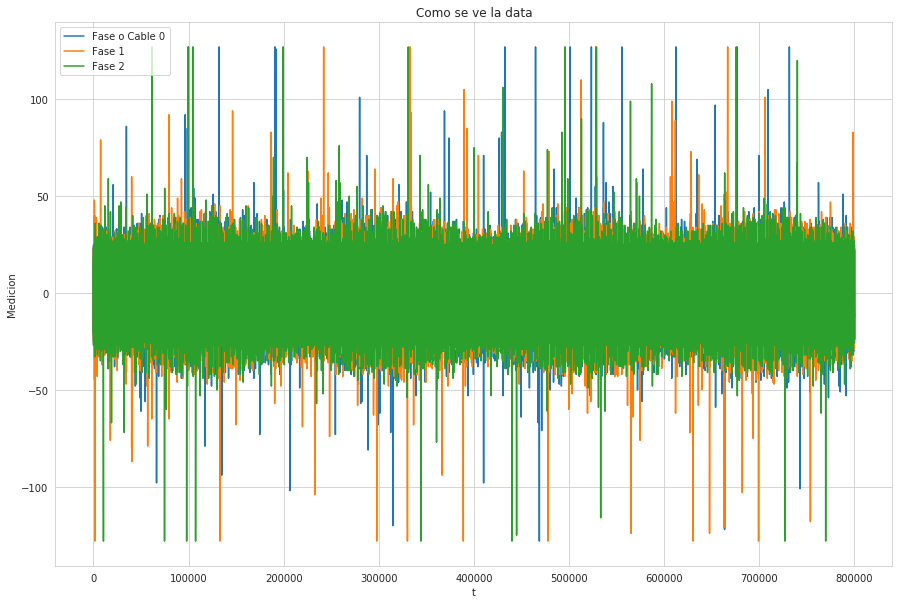

In [38]:
plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Fase o Cable 0')
plt.plot(signals[0, 1, :], label='Fase 1')
plt.plot(signals[0, 2, :], label='Fase 2')
plt.title('Como se ve la data')
plt.ylabel('Medicion')
plt.xlabel('t')
plt.legend()
plt.show()

### Target
Aqui se observa para distintas id de señales, pero lo importante es el `id_measurement` que se refiere al id de la medicion, y son las mediciones las que analizamos, si es que sus 3 fases poseen problemas nos lo dira el valor booleano de `target`

In [21]:
# en target podemos observar donde se encuentran los fallos en las powerlines
train_df = pd.read_csv('../input/metadata_train.csv')
train_df

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1
5,5,1,2,1
6,6,2,0,0
7,7,2,1,0
8,8,2,2,0
9,9,3,0,0


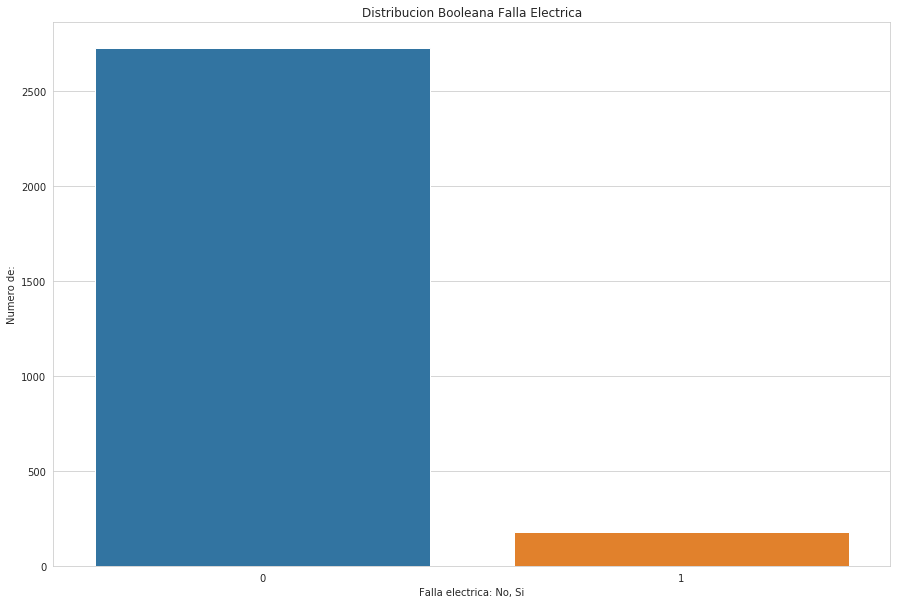

In [40]:
# tomamos cada 3 datos, de manera que tendremos las mediciones
target = train_df['target'][::3]

plt.figure(figsize=(15, 10))
plt.title('Distribucion Booleana Falla Electrica')
c = sns.countplot(target)
c.set_xlabel('Falla electrica: No, Si')
c.set_ylabel('Numero de:')
plt.show()

## 2 - Smoothing by mean
Esta idea es promediar pedazos, combinar para conquistar

In [43]:
def sample(signal, kernel_size):
    """
    Toma una signal de hasta 3 dimensiones y con el kernel size, modifica la cantidad de mediciones
    por ejemplo sample(Signal(333,3,8000), 8) -> NuevaSignal(333,3,1000) con datos promedidas
    """
    # definimos la forma de como saldra la data, la cantidad de mediciones las modifica
    mediciones = signal.shape[2]//kernel_size
    sampled = np.zeros((signal.shape[0], signal.shape[1], mediciones))
    for i in range(mediciones): # ejemplo para kernel size 100
        intervalo_inferior = kernel_size * i  # 0, 100, 200, 300, ...
        intervalo_superior = min(kernel_size * (i + 1), signal.shape[2]) # tomamos 100, 200, 300, ... maxData
        # aqui es la parte importante, cortamos la data entre intervalo inferior-superior
        # especificamos que en ese intervalo y axis queremos promediar np.mean(.., axis=2)
        # de esa manera sampled[:,:,i] recibe ese intervalo
        sampled[:, :, i] = np.mean(signal[:, :, intervalo_inferior:intervalo_superior], axis=2) 
    return sampled

In [56]:
# ejecutamos la catidad de kernel
# a mayor kernel, mas smothing pero aumenta la perdida de data
kernel_size = 20
sampled = sample(signals, kernel_size)

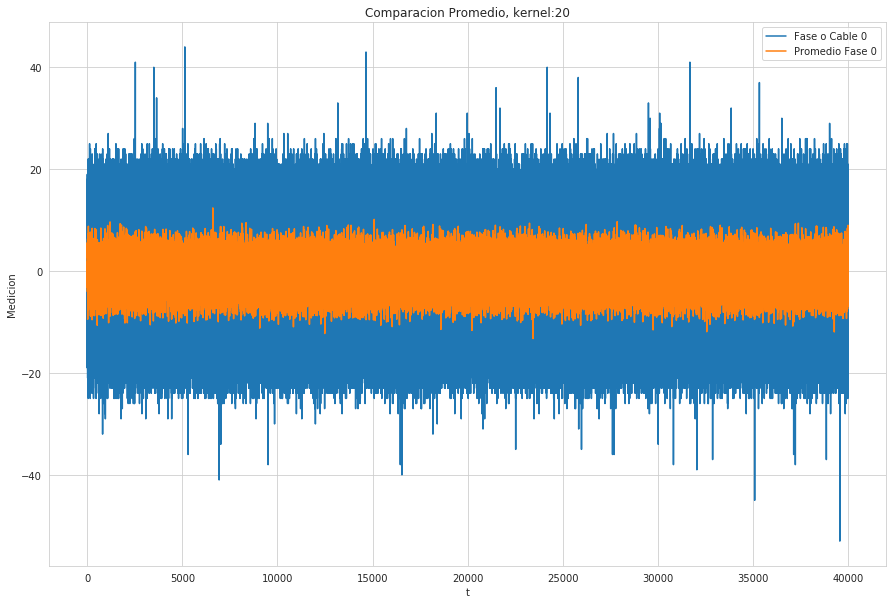

In [57]:
plt.figure(figsize=(15, 10))

plt.plot(signals[0, 0, ::kernel_size], label='Fase o Cable 0')
# plt.plot(signals[0, 1, ::kernel_size], label='Fase 1')
# plt.plot(signals[0, 2, ::kernel_size], label='Fase 2')

plt.plot(sampled[0, 0, :], label='Promedio Fase 0')
# plt.plot(sampled[0, 1, :], label='Promedio Fase 1')
# plt.plot(sampled[0, 2, :], label='Promedio Fase 2')


plt.title(f'Comparacion Promedio, kernel:{kernel_size}')
plt.ylabel('Medicion')
plt.xlabel('t')


plt.legend()
plt.show()

Usar el plot anterior como referencias, pues estamos omitiendo muchisimos datos, puede ser misleading si observamos los 3, en la mayoria de datos se omitieron los peaks sin embargo sobrevivio 1, haciendo ver la data muy distinta

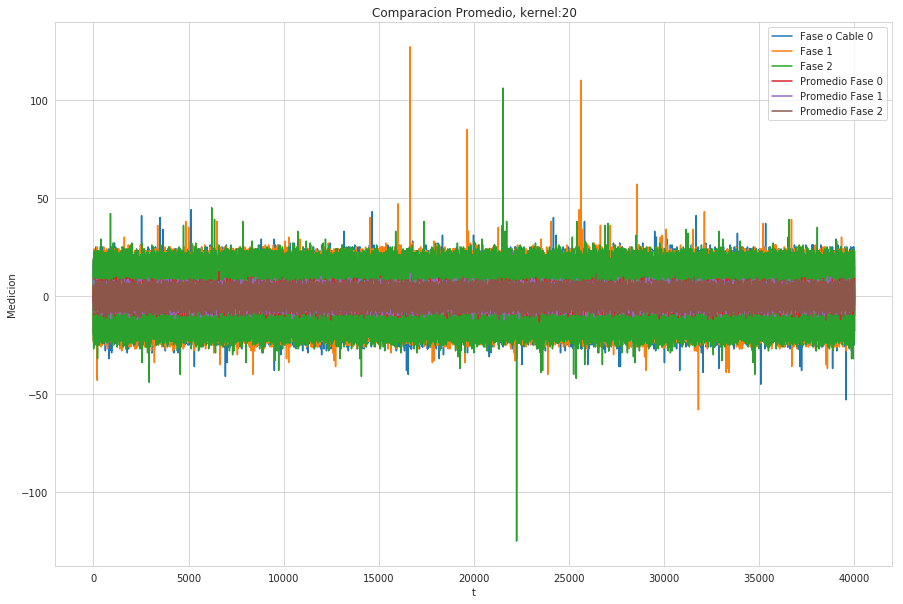

In [58]:

plt.figure(figsize=(15, 10))

plt.plot(signals[0, 0, ::kernel_size], label='Fase o Cable 0')
plt.plot(signals[0, 1, ::kernel_size], label='Fase 1')
plt.plot(signals[0, 2, ::kernel_size], label='Fase 2')

plt.plot(sampled[0, 0, :], label='Promedio Fase 0')
plt.plot(sampled[0, 1, :], label='Promedio Fase 1')
plt.plot(sampled[0, 2, :], label='Promedio Fase 2')


plt.title(f'Comparacion Promedio, kernel:{kernel_size}')
plt.ylabel('Medicion')
plt.xlabel('t')


plt.legend()
plt.show()

# 3 - FFT Denoising

#### Denoising algorithm
The denoising steps are the following :
- Aplicar FFT a la signals, pasar de tiempo -> frecuencia
- Computar las frecuencias ascoaidas a cada coeficiente
- Mantener coeficientes bajo cierto treshhold (el ruido es de alta frecuencia)
- IFFT para pasar la data: frecuencia -> tiempo


In [67]:
# aqui el filtrado, donde se utiliza el correspondiente a las librerias que ya estan adaptadas en C
# para funcionar mas rapido
def filter_signal(signal, limite=1e8):
    # real fast fourier transform, asume data real, y explota la simetria
    # ahorrandose calculo de la mitad de las señales
    fourier = rfft(signal)
    # d: sampling frecuency, corresponde a los 20ms / data total
    frequencias = rfftfreq(signal.size, d=20e-3/signal.size)
    # igualamos a 0 en lugar de eliminar, para manener la shape
    fourier[frequencias > limite] = 0
    return irfft(fourier)

print('Para nuestros datos, el spacing entre frecuencias debe de ser:',20e-3/signals[0,0,:].size)

Para nuestros datos, el spacing entre frecuencias debe de ser: 2.5e-08


### Probando limites
Si tenemos un limite muy bajo, desapareceran comportamientos importantes de la data, por tanto hemos de probar

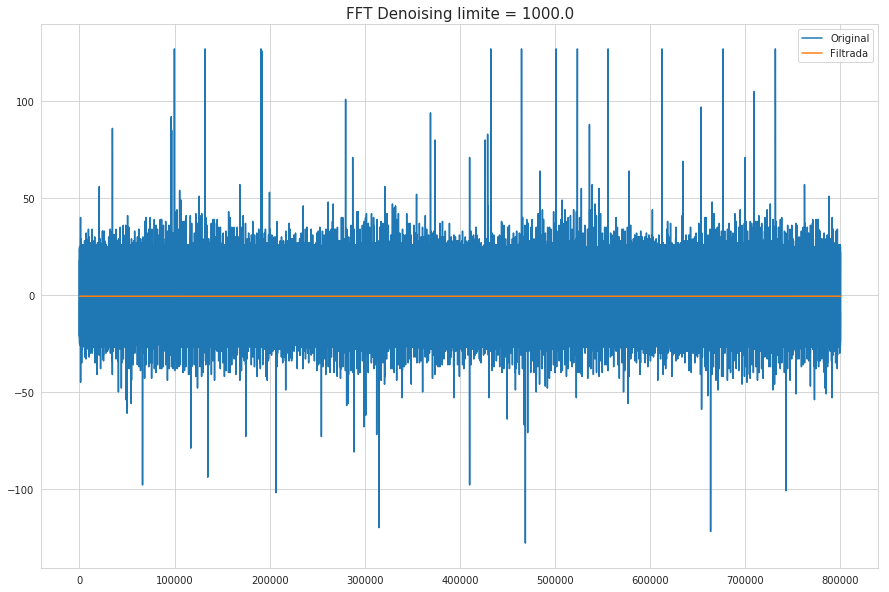

In [71]:
limite = 1e3
filtered = filter_signal(signals[0, 0, :], limite)

plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Original')
plt.plot(filtered, label='Filtrada')
plt.legend()
plt.title(f"FFT Denoising limite = {limite}", size=15)
plt.show()

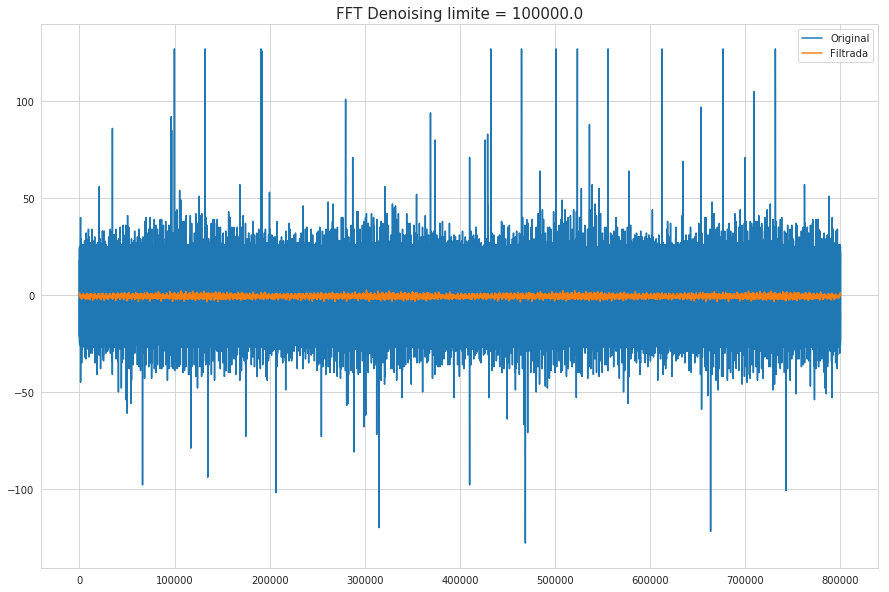

In [72]:
limite = 1e5
filtered = filter_signal(signals[0, 0, :], limite)

plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Original')
plt.plot(filtered, label='Filtrada')
plt.legend()
plt.title(f"FFT Denoising limite = {limite}", size=15)
plt.show()

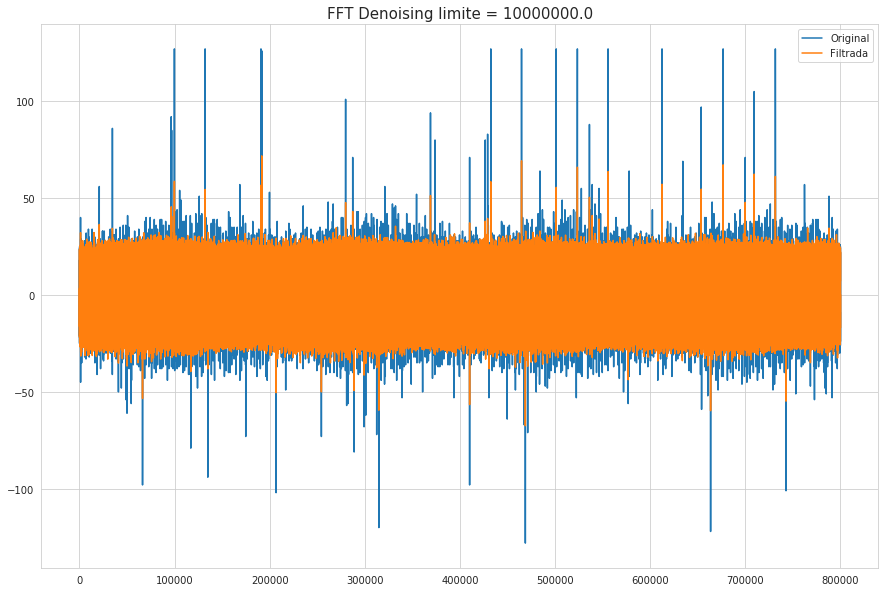

In [73]:
limite = 1e7
filtered = filter_signal(signals[0, 0, :], limite)

plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Original')
plt.plot(filtered, label='Filtrada')
plt.legend()
plt.title(f"FFT Denoising limite = {limite}", size=15)
plt.show()

y asi, hemos conseguido un metood para quitar altas frecuencias correspondientes al ruido, 

Si se gusta continuar el siguiente paso corresponde a obtener los $999 \times 8000000$ coeficientes para entonces alimentarlos a un clasificador.
